In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import shutil
import os
import csv
import imutils
from EXITlib import Image_manipulation
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [6]:
TRAIN_FOLDER = './data/train'
VAL_FOLDER = './data/val'
TEST_FOLDER = './data/test'
IMAGE_SIZE = 224

### 1. generate object images with perspective

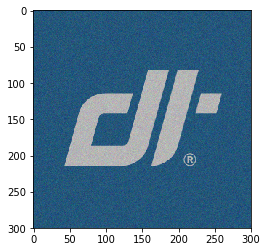

In [44]:
def add_noise(image):
    row,col,ch= image.shape
    mean = np.random.randint(100, 255)
    var = np.random.randint(0, 300)
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,3))
    
    alpha = image[:, :, 3]
    gauss = np.dstack([gauss, alpha])
    
    image = image + gauss
    min = np.min(image)
    max = np.max(image)
    r = max-min
    image = np.int32((image + (-min) )/r * 255)
    image = image.astype(np.uint8)
    return image
image = cv2.imread('./source-data/object/dt0.png', cv2.IMREAD_UNCHANGED)
image = add_noise(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [184]:
''' EXAMPLE
_ = get_distort_image({
    'image_path':'source-data/object/dt1.png',
    'top_left': {'x':40, 'y':40},
    'top_right': {'x':44, 'y':47},
    'bottom_left': {'x':40, 'y':33},
    'bottom_right': {'x':39, 'y':35},
})
'''
image_manipulation = Image_manipulation.Image_manipulation()
def get_distort_image(image_data):
    image = cv2.imread(image_data['image_path'], cv2.IMREAD_UNCHANGED)
    image = add_noise(image)
    # hue
    temp_alpha = image[:, :, 3]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    rand = np.random.randint(0, 30)
    image[:, :, 0] += rand
    image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
    # convert back with alpha channel
    image = cv2.merge((
        image[:, :, 0], 
        image[:, :, 1], 
        image[:, :, 2], 
        temp_alpha))
    
    cols, rows, ch = image.shape

    output_rows = output_cols = np.random.randint(30, IMAGE_SIZE/2)
    SMALL_RECT_LEFT = output_rows*2/6
    SMALL_RECT_RIGHT = output_rows*4/6
    SMALL_RECT_TOP = output_cols*2/6
    SMALL_RECT_BOTTOM = output_cols*4/6
    
    # random all points
    left = np.random.randint(0, SMALL_RECT_LEFT, size=2)
    right = np.random.randint(SMALL_RECT_RIGHT, output_cols, size=2)
    top = np.random.randint(0, SMALL_RECT_TOP, size=2)
    bottom = np.random.randint(SMALL_RECT_BOTTOM, output_rows, size=2)
    
    # declare points
    pts1 = np.float32([[image_data['top_left']['x'], image_data['top_left']['y']],
                       [cols - image_data['top_right']['x'], image_data['top_right']['y']],
                       [image_data['bottom_left']['x'], rows - image_data['bottom_left']['y']],
                       [cols - image_data['bottom_right']['x'], rows - image_data['bottom_right']['y']]])

    top_left = [left[0], top[0]]
    right_top = [right[0], top[1]]
    left_bottom = [left[1], bottom[0]]
    right_bottom = [right[1], bottom[1]]
    pts2 = np.float32([top_left, right_top, left_bottom, right_bottom])


    # transform
    perspectiveTransform = cv2.getPerspectiveTransform(pts1,pts2)
    image = cv2.warpPerspective(image, perspectiveTransform, (output_cols, output_rows))
    
    angle = np.random.randint(-180, 181)
    image, pts3 = image_manipulation.rotate_bound(image, angle, pts2)
    
    # draw bounding box
#     lines = [np.int32([top_left, right_top, right_bottom, left_bottom])]
#     cv2.polylines(image, lines, True, color=(0, 0, 255, 255), thickness=1)
    
    return image, pts3

In [185]:
# gen_augmented_background('source-data/background/bg1.jpg')
def gen_augmented_background(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    cols, rows, _ = image.shape
    x = np.random.randint(0, cols - IMAGE_SIZE)
    y = np.random.randint(0, rows - IMAGE_SIZE)
    image = image[x:x+IMAGE_SIZE, y:y+IMAGE_SIZE]
    return image

In [186]:
def overlay_image(top_image, background_image, x_offset, y_offset):
    y1, y2 = y_offset, y_offset + top_image.shape[0]
    x1, x2 = x_offset, x_offset + top_image.shape[1]

    alpha_top = top_image[:, :, 3] / 255.0
    alpha_background = 1.0 - alpha_top
    image = background_image[:,:,:]

    for c in range(0, 3):
        a1 = alpha_top * top_image[:, :, c]
        a2 = alpha_background * background_image[y1:y2, x1:x2, c]
        image[y1:y2, x1:x2, c] = (a1 + a2)
    return image

In [198]:
object_image_datas = [{
        'image_path': 'source-data/object/dt0.png',
        'top_left': {'x':0, 'y':0},
        'top_right': {'x':0, 'y':0},
        'bottom_left': {'x':0, 'y':0},
        'bottom_right': {'x':0, 'y':0},
    },{
        'image_path': 'source-data/object/dt1.png',
        'top_left': {'x':40, 'y':40},
        'top_right': {'x':44, 'y':47},
        'bottom_left': {'x':40, 'y':33},
        'bottom_right': {'x':39, 'y':35},
    },{
        'image_path': 'source-data/object/dt2.png',
        'top_left': {'x':14, 'y':22},
        'top_right': {'x':12, 'y':17},
        'bottom_left': {'x':14, 'y':8},
        'bottom_right': {'x':8, 'y':11},
    }]
background_image_paths = ['source-data/background/bg1.jpg',
                            'source-data/background/bg2.jpg',
                            'source-data/background/bg3.jpg',
                            'source-data/background/bg4.jpg']

def gen_images(num_image, path):
    if os.path.isdir(path):
        shutil.rmtree(path)
    os.mkdir(path)
    
    corners = []
    for i in range(num_image):
        
        # random index
        object_image_index = np.random.randint(0, len(object_image_datas))
        background_image_index = np.random.randint(0, len(background_image_paths))

        # gen images
        object_image, one_image_corners = get_distort_image(object_image_datas[object_image_index])
        bg_image = gen_augmented_background(background_image_paths[background_image_index])

        # merge images
        obj_rows, obj_cols, _ = object_image.shape
        bg_rows, bg_cols, _ = bg_image.shape
        
        offset_x = np.random.randint(0, bg_cols - obj_cols)
        offset_y = np.random.randint(0, bg_rows - obj_rows)
        
        one_image_corners[:, 0] += offset_x
        one_image_corners[:, 1] += offset_y
        
        image = overlay_image(object_image, bg_image, offset_x, offset_y)
        
        # save image
#         resequence_corner = np.int32([one_image_corners[0],
#                                       one_image_corners[1],
#                                       one_image_corners[3],
#                                       one_image_corners[2]])
#         cv2.polylines(image, [resequence_corner], True, color=(0, 0, 255, 255), thickness=1)
        cv2.imwrite(f'{path}/object_image{i}.png',image)
        
        # save points
        one_image_corners = np.concatenate(one_image_corners) # concatenate all points to one array
        corners.append(one_image_corners)
    
    file = open(f'{path}/corners.csv', 'w')
    with file:
        writer = csv.writer(file)
        writer.writerows(corners)



In [199]:
# gen_images(4112, TRAIN_FOLDER)
gen_images(10, TEST_FOLDER)
# gen_images(512, VAL_FOLDER)

(555, 559, 4)
(530, 523, 4)
(555, 559, 4)
(555, 559, 4)
(300, 300, 4)
(530, 523, 4)
(555, 559, 4)
(300, 300, 4)
(530, 523, 4)
(300, 300, 4)


### 2. Train

In [8]:
import csv
import math

import cv2
from keras.applications.mobilenet import MobileNet, _depthwise_conv_block
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import *
from keras.utils import Sequence

ALPHA = 0.25
# IMAGE_SIZE = 128 move to top

EPOCHS = 5000
PATIENCE = 100


class DataSequence(Sequence):

    def __load_images(self, dataset):
        out = []
        for file_name in dataset:
            im = cv2.resize(cv2.imread(file_name), (self.image_size, self.image_size))
            out.append(im)

        return np.array(out)

    def __init__(self, csv_file, image_path, image_size, batch_size=32, feature_scaling=False):
        self.csv_file = csv_file
        with open(self.csv_file, "r") as file:
            reader = csv.reader(file, delimiter=",")
            arr = list(reader)

        self.y = np.zeros((len(arr), 8))
        self.x = []
        self.image_size = image_size

        # for index, (path, class_id, width, height, x0, y0, x1, y1) in enumerate(arr):
        for index, coner_points in enumerate(arr):
            self.y[index] = np.array(coner_points)
            self.x.append(f'{image_path}/object_image{index}.png')

        self.batch_size = batch_size
        self.feature_scaling = feature_scaling
        if self.feature_scaling:
            dataset = self.__load_images(self.x)
            broadcast_shape = [1, 1, 1]
            broadcast_shape[2] = dataset.shape[3]

            self.mean = np.mean(dataset, axis=(0, 1, 2))
            self.mean = np.reshape(self.mean, broadcast_shape)
            self.std = np.std(dataset, axis=(0, 1, 2))
            self.std = np.reshape(self.std, broadcast_shape) + K.epsilon()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = self.__load_images(batch_x).astype('float32')
        if self.feature_scaling:
            images -= self.mean
            images /= self.std

        return images, batch_y


def create_model(size, alpha):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     kernel_initializer='he_normal',
                     input_shape=(size, size, 3)))
#     model.add(Dropout(0.25))
    model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
    print(model.output_shape)
    model.add(MaxPooling2D((27, 27)))
    model.add(Conv2D(8, (1, 1), activation='relu'))
    print(model.output_shape)
    model.add(Reshape((8,)))
#     model.add(Dropout(0.25))
#     model.add(Flatten())
#     model.add(Dense(8))
    return model

def create_model2(size, alpha):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(size, size, 3)))
    model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.3))
    model.add(Dense(8))
    return model

def create_mobile_net_model(size, alpha):
    model_net = MobileNet(input_shape=(size, size, 3), include_top=False, alpha=alpha)
    x = _depthwise_conv_block(model_net.layers[-1].output, 1024, alpha, 1, block_id=14)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(4, 4))(x)
    x = Conv2D(8, kernel_size=(1, 1), padding="same")(x)
    x = Reshape((8,))(x)
    
#     if I use flatten it will cause overfitting, I don't know why
#     x = Flatten()(x)
#     x = Dense(8)(x)

    return Model(inputs=model_net.input, outputs=x)


def train(model, epochs, image_size):
    train_datagen = DataSequence("./data/train/corners.csv", "./data/train", image_size)
    validation_datagen = DataSequence("./data/val/corners.csv", "./data/val", image_size)

    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])
    checkpoint = ModelCheckpoint("model-{val_acc:.2f}.h5", monitor="val_acc", verbose=1, save_best_only=True,
                                 save_weights_only=True, mode="auto", period=1)
    stop = EarlyStopping(monitor="val_acc", patience=PATIENCE, mode="auto")

    model.fit_generator(train_datagen, steps_per_epoch=1028, epochs=epochs, validation_data=validation_datagen,
                        validation_steps=22, callbacks=[checkpoint, stop])


/Users/epinyoanun/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
def main():
    model = create_mobile_net_model(IMAGE_SIZE, ALPHA)
#     model = create_model2(IMAGE_SIZE, ALPHA)
    train(model, EPOCHS, IMAGE_SIZE)


if __name__ == "__main__":
    main()


Epoch 1/5000
1028/1028 [==============================] - 187s 182ms/step - loss: 305.3089 - acc: 0.7064 - val_loss: 42.2550 - val_acc: 0.8736

Epoch 00001: val_acc improved from -inf to 0.87358, saving model to model-0.87.h5
Epoch 2/5000
1028/1028 [==============================] - 180s 175ms/step - loss: 13.7456 - acc: 0.8826 - val_loss: 26.1745 - val_acc: 0.8707

Epoch 00002: val_acc did not improve from 0.87358
Epoch 3/5000
1028/1028 [==============================] - 180s 175ms/step - loss: 7.4707 - acc: 0.9039 - val_loss: 15.9888 - val_acc: 0.8935

Epoch 00003: val_acc improved from 0.87358 to 0.89347, saving model to model-0.89.h5
Epoch 4/5000
1028/1028 [==============================] - 180s 175ms/step - loss: 6.3785 - acc: 0.9161 - val_loss: 16.0462 - val_acc: 0.8963

Epoch 00004: val_acc improved from 0.89347 to 0.89631, saving model to model-0.90.h5
Epoch 5/5000
1028/1028 [==============================] - 180s 175ms/step - loss: 6.4587 - acc: 0.9232 - val_loss: 18.4666 - va

1028/1028 [==============================] - 180s 175ms/step - loss: 0.5845 - acc: 0.9778 - val_loss: 5.3455 - val_acc: 0.9347

Epoch 00042: val_acc did not improve from 0.94034
Epoch 43/5000
1028/1028 [==============================] - 179s 175ms/step - loss: 0.5553 - acc: 0.9781 - val_loss: 7.9729 - val_acc: 0.9233

Epoch 00043: val_acc did not improve from 0.94034
Epoch 44/5000
1028/1028 [==============================] - 180s 175ms/step - loss: 0.7728 - acc: 0.9744 - val_loss: 6.9808 - val_acc: 0.9389

Epoch 00044: val_acc did not improve from 0.94034
Epoch 45/5000
1028/1028 [==============================] - 180s 175ms/step - loss: 0.6480 - acc: 0.9780 - val_loss: 7.7656 - val_acc: 0.9290

Epoch 00045: val_acc did not improve from 0.94034
Epoch 46/5000
1028/1028 [==============================] - 180s 175ms/step - loss: 0.6279 - acc: 0.9767 - val_loss: 4.7622 - val_acc: 0.9318

Epoch 00046: val_acc did not improve from 0.94034
Epoch 47/5000
1028/1028 [=============================

### 3. Validation/ gen prediction lines

In [9]:
image = cv2.resize(cv2.imread('data/test/1.png', cv2.IMREAD_UNCHANGED), (IMAGE_SIZE, IMAGE_SIZE))

error: /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/resize.cpp:4044: error: (-215) ssize.width > 0 && ssize.height > 0 in function resize


In [11]:
import shutil
import glob

OUTPUT_TEST_PATH = './data/output_test'
if os.path.isdir(OUTPUT_TEST_PATH):
    shutil.rmtree(OUTPUT_TEST_PATH)
model = create_mobile_net_model(IMAGE_SIZE, ALPHA)
model.load_weights('model-0.92.h5')

image_paths = sorted(glob.glob('{}/*png'.format(TEST_FOLDER)))
for i in range(len(image_paths)):
    image_path = image_paths[i]
    image = cv2.resize(cv2.imread(image_path), (IMAGE_SIZE, IMAGE_SIZE))
    points = model.predict(x=np.array([image]))[0].astype(int)
    points = np.array([[points[0], points[1]], 
                       [points[2], points[3]], 
                       [points[6], points[7]], 
                       [points[4], points[5]]])
#     print('points:', points)
    
#     with open('data/train/corners.csv', "r") as file:
#         reader = csv.reader(file, delimiter=",")
#         arr = list(reader)
#         points = [np.int32(float(str)) for str in arr[0]]
#         points = np.array([[points[0], points[1]], 
#                            [points[2], points[3]], 
#                            [points[6], points[7]], 
#                            [points[4], points[5]]])
#         print('points:', points)
    
    cv2.polylines(image, [points], True, (255,255,255))
    pathlib.Path(OUTPUT_TEST_PATH).mkdir(parents=True, exist_ok=True)
    cv2.imwrite(f'{OUTPUT_TEST_PATH}/image{i}.png', image)